# NetBox Topology Exporter PoC

Initialize parameters

In [108]:
export_sites = ["nr-1"]
nb_api_url = 'https://demo.netbox.dev'
nb_api_token = 'd2fa978199167d24f75aa477fc24a1a59eba9db7'
export_device_roles = ["router", "core-switch", "access-switch", "distribution-switch", "tor-switch"]

Initialize Netbox API client

In [109]:
import pynetbox
nb = pynetbox.api(
    nb_api_url,
    token=nb_api_token,
    threading=True,
)

Create a `devices` list of Devices for the site. Each Device is stored in the list as a dictionary:

```
{
    "id": device.id,
    "type": "device",
    "name": device.name,
    "node_id": <index of this device object in the nodes list>,
}
```

Create an `interfaces` list of Interfaces for the Devices selected above, which have Ethernet connections via Cables. Each Interface is stored in the list as a dictionary:

```
{
    "id": interface.id,
    "type": "interface",
    "name": interface.name,
    "node_id": <index of this interface object in the nodes list>,
}
```

Both Device and Interface dictionary objects are also stored in a common `nodes` list, to create unique IDs to be later used when creating a graph object with them as nodes.

Also, for quick indexing, create separate lists of Device, Interface and Cable IDs.

In [110]:
s = nb.dcim.sites.get(name=export_sites)
nodes, devices, interfaces = [], [], []
device_ids, interface_ids, cable_ids = [], [], []
for device in list(nb.dcim.devices.filter(site_id=s.id,role=export_device_roles)):
    d = {
        "id": device.id,
        "type": "device",
        "name": device.name,
        "node_id": -1,
    }
    nodes.append(d)
    d["node_id"] = len(nodes) - 1
    devices.append(d)
    device_ids.append(device.id) # index of the device in the devices list will match its ID index in device_ids list
    for interface in list(nb.dcim.interfaces.filter(device_id=device.id)):
        if "base" in interface.type.value and interface.cable: # only connected ethernet interfaces
            print(device.name, ":", interface, ":", interface.type.value)
            i = {
                "id": interface.id,
                "type": "interface",
                "name": interface.name,
                "node_id": -1,
            }
            nodes.append(i)
            i["node_id"] = len(nodes) - 1
            interfaces.append(i)
            interface_ids.append(interface.id) # index of the interface in the interfaces list will match its ID index in interface_ids list
            cable_ids.append(interface.cable.id)

nr-rtr-01 : Ethernet1/1 : 10gbase-x-sfpp
nr-rtr-01 : Ethernet1/2 : 10gbase-x-sfpp
nr-sw-01 : Ethernet1/1 : 10gbase-x-sfpp
nr-sw-01 : Ethernet1/2 : 10gbase-x-sfpp
nr-sw-02 : Ethernet1/1 : 10gbase-x-sfpp
nr-sw-02 : Ethernet1/2 : 10gbase-x-sfpp


Filter Cables list to only those that are interconnecting Devices. Leave Circuits out.

Create a Graph object representing ownership of Interfaces by Devices, and interconnections between Interfaces.

In [111]:
import networkx as nx
G = nx.Graph(name=export_sites)

for cable in list(nb.dcim.cables.filter(id=cable_ids)):
    if len(cable.a_terminations) == 1 and len(cable.b_terminations) == 1:
        int_a = cable.a_terminations[0]
        int_b = cable.b_terminations[0]
        if isinstance(int_a, pynetbox.models.dcim.Interfaces) and isinstance(int_b, pynetbox.models.dcim.Interfaces):
            print("{}:{} <> {}:{}".format(int_a.device,int_a,int_b.device,int_b))
            d_a = devices[device_ids.index(int_a.device.id)]
            d_b = devices[device_ids.index(int_b.device.id)]
            G.add_nodes_from([
                (d_a["node_id"], {"side": "a", "type": "device", "device": d_a}),
                (d_b["node_id"], {"side": "b", "type": "device", "device": d_b}),
            ])
            i_a = interfaces[interface_ids.index(int_a.id)]
            i_b = interfaces[interface_ids.index(int_b.id)]
            G.add_nodes_from([
                (i_a["node_id"], {"side": "a", "type": "interface", "interface": i_a}),
                (i_b["node_id"], {"side": "b", "type": "interface", "interface": i_b}),
            ])
            G.add_edges_from([
                (d_a["node_id"], i_a["node_id"]),
                (d_b["node_id"], i_b["node_id"]),
            ])
            G.add_edges_from([
                (i_a["node_id"], i_b["node_id"]),
            ])
print(G)

nr-rtr-01:Ethernet1/1 <> nr-sw-01:Ethernet1/1
nr-rtr-01:Ethernet1/2 <> nr-sw-02:Ethernet1/1
nr-sw-01:Ethernet1/2 <> nr-sw-02:Ethernet1/2
Graph named 'nr-1' with 9 nodes and 9 edges


Visualize the graphs for quick validation

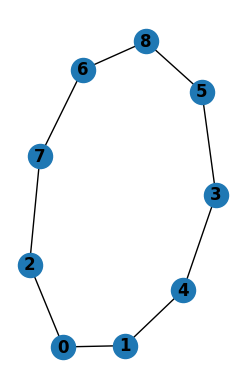

In [112]:
import matplotlib.pyplot as plt
subax1 = plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')

Serialize the graph into GML format and save it as `<export_sites>.gml`

In [113]:
print("\n".join(nx.generate_gml(G)))
nx.write_gml(G, export_sites+".gml")


graph [
  name "nr-1"
  node [
    id 0
    label "0"
    side "a"
    type "device"
    device [
      id 112
      type "device"
      name "nr-rtr-01"
      node_id 0
    ]
  ]
  node [
    id 1
    label "3"
    side "a"
    type "device"
    device [
      id 113
      type "device"
      name "nr-sw-01"
      node_id 3
    ]
  ]
  node [
    id 2
    label "1"
    side "a"
    type "interface"
    interface [
      id 1825
      type "interface"
      name "Ethernet1/1"
      node_id 1
    ]
  ]
  node [
    id 3
    label "4"
    side "b"
    type "interface"
    interface [
      id 1829
      type "interface"
      name "Ethernet1/1"
      node_id 4
    ]
  ]
  node [
    id 4
    label "6"
    side "b"
    type "device"
    device [
      id 114
      type "device"
      name "nr-sw-02"
      node_id 6
    ]
  ]
  node [
    id 5
    label "2"
    side "a"
    type "interface"
    interface [
      id 1826
      type "interface"
      name "Ethernet1/2"
      node_id 2
    ]


Also export in Cytoscape JSON format `<export_sites>.cyjs`

In [114]:
import json
cyjs = nx.cytoscape_data(G)
print(json.dumps(cyjs, indent=4))
with open(export_sites + ".cyjs", 'w', encoding='utf-8') as f:
    json.dump(cyjs, f, indent=4)

{
    "data": [
        [
            "name",
            "nr-1"
        ]
    ],
    "directed": false,
    "multigraph": false,
    "elements": {
        "nodes": [
            {
                "data": {
                    "side": "a",
                    "type": "device",
                    "device": {
                        "id": 112,
                        "type": "device",
                        "name": "nr-rtr-01",
                        "node_id": 0
                    },
                    "id": "0",
                    "value": 0,
                    "name": "0"
                }
            },
            {
                "data": {
                    "side": "a",
                    "type": "device",
                    "device": {
                        "id": 113,
                        "type": "device",
                        "name": "nr-sw-01",
                        "node_id": 3
                    },
                    "id": "3",
                    "valu